In [1]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import itertools
import lightgbm as lgbm
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

import matplotlib.pyplot as plt
import graphviz

from script import *
from feature_engineering import *
import db_operations as dbop
from constants import *
import data_process as dp

import time

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
pd.set_option('display.max_rows',200)
idx = pd.IndexSlice
agg_operations =['mean','median','max','min','std','size']

In [3]:
%time df = pd.read_hdf(os.path.join('datasets','df_20140101.h5'),key='data')
df = df.sort_index()
df.shape
df.columns

Wall time: 4.53 s


(4593560, 64)

Index(['open', 'high', 'low', 'close', 'vol', 'amt', 'adj_factor', 'avg',
       'close0', 'avg0', 'pct', 'turnover_rate', 'turnover_rate_f',
       'volume_ratio', 'pe', 'pe_ttm', 'pb', 'ps', 'ps_ttm', 'total_share',
       'float_share', 'free_share', 'total_mv', 'circ_mv', 'pb*pe_ttm',
       'pb*pe', '5ma', '10ma', '20ma', '40ma', '60ma', '120ma', '250ma',
       'close/5ma', 'close/10ma', 'close/20ma', 'close/40ma', 'close/60ma',
       'close/120ma', 'close/250ma', '60ma_pct', '20ma_pct', 'p5max_abs_pct',
       'p10max_abs_pct', '30ma', '30ma_pct', 'close/30ma', 'prev_close',
       'day_pct', 'close0_rank', 'close0_pct', 'prev_pct', 'prev_day_pct',
       'sell_at', 'sell_at0', 'sell_date', 'sell_idx', 'buy_at', 'buy_at0',
       'max', 'max_idx', 'idx', 'is_selled', 'r'],
      dtype='object')

In [25]:
eval_date_start = '2016-01-01'
mask_date = df.index.get_level_values('date')>='2016-01-01'


In [5]:
%time df['5ma_pct'] = df['5ma'].sort_index().groupby('code').pct_change()*100 # 7s

target_col = '5ma_pct'
min_periods=1

for k in [5,10,15,20,25,30]:
    %time tmp = groupby_rolling(df[[target_col]],level="code",window=k,ops=['mean','median','std'],min_periods=min_periods)
    df[tmp.columns] = tmp

for k in [5,10,15,20,25,30]:
#     %time tmp = groupby_rolling(df[[target_col,'close']],level="code",window=k,ops=['mean','median','std'],min_periods=min_periods)
#     df[tmp.columns] = tmp
    df['p{}mean-std_5ma_pct'.format(k)] = df['p{}mean_5ma_pct'.format(k)]-df['p{}std_5ma_pct'.format(k)]
    
list(df.columns)

Wall time: 6.02 s
Wall time: 11.6 s
Wall time: 9.69 s
Wall time: 9.71 s
Wall time: 10.5 s
Wall time: 10 s
Wall time: 11.7 s


['open',
 'high',
 'low',
 'close',
 'vol',
 'amt',
 'adj_factor',
 'avg',
 'close0',
 'avg0',
 'pct',
 'turnover_rate',
 'turnover_rate_f',
 'volume_ratio',
 'pe',
 'pe_ttm',
 'pb',
 'ps',
 'ps_ttm',
 'total_share',
 'float_share',
 'free_share',
 'total_mv',
 'circ_mv',
 'pb*pe_ttm',
 'pb*pe',
 '5ma',
 '10ma',
 '20ma',
 '40ma',
 '60ma',
 '120ma',
 '250ma',
 'close/5ma',
 'close/10ma',
 'close/20ma',
 'close/40ma',
 'close/60ma',
 'close/120ma',
 'close/250ma',
 '60ma_pct',
 '20ma_pct',
 'p5max_abs_pct',
 'p10max_abs_pct',
 '30ma',
 '30ma_pct',
 'close/30ma',
 'prev_close',
 'day_pct',
 'close0_rank',
 'close0_pct',
 'prev_pct',
 'prev_day_pct',
 'sell_at',
 'sell_at0',
 'sell_date',
 'sell_idx',
 'buy_at',
 'buy_at0',
 'max',
 'max_idx',
 'idx',
 'is_selled',
 'r',
 '5ma_pct',
 'p5mean_5ma_pct',
 'p5median_5ma_pct',
 'p5std_5ma_pct',
 'p10mean_5ma_pct',
 'p10median_5ma_pct',
 'p10std_5ma_pct',
 'p15mean_5ma_pct',
 'p15median_5ma_pct',
 'p15std_5ma_pct',
 'p20mean_5ma_pct',
 'p20media

In [6]:
%time df_tmp = df[mask_date] # 4s

quantiles = [0.5,0.8,0.9,0.95,0.99]
df_quantile = pd.DataFrame(columns=quantiles)

for k in [5,10,15,20,25,30]:
#     print('\nk={}'.format(k))
    for p in quantiles:
        col1 = 'p{}mean_5ma_pct'.format(k)
        col2 = 'p{}mean-std_5ma_pct'.format(k)
        df_quantile.loc[col1,p] = df[col1].quantile(p)
        df_quantile.loc[col2,p] = df[col2].quantile(p)
#         '{}:{:.1%}={:.3f}'.format(col1,p,df[col1].quantile(p))
#         '{}:{:.1%}={:.3f}'.format(col2,p,df[col2].quantile(p))

df_quantile

Wall time: 2.43 s


,0.50,0.80,0.90,0.95,0.99
p5mean_5ma_pct,0.0247288,0.749466,1.28705,1.90599,3.91871
p5mean-std_5ma_pct,-0.536927,0.132062,0.522473,0.938066,2.24703
p10mean_5ma_pct,0.0179279,0.611594,1.0413,1.51687,3.03925
p10mean-std_5ma_pct,-0.73381,-0.155048,0.113123,0.372153,1.09548
p15mean_5ma_pct,0.0135601,0.529096,0.895657,1.29339,2.51983
p15mean-std_5ma_pct,-0.840915,-0.303747,-0.0822442,0.113044,0.624762
p20mean_5ma_pct,0.00350311,0.471452,0.80449,1.1603,2.20205
p20mean-std_5ma_pct,-0.913115,-0.400348,-0.193278,-0.0348546,0.356693
p25mean_5ma_pct,-0.00207615,0.429371,0.735721,1.06207,1.97022
p25mean-std_5ma_pct,-0.961279,-0.470762,-0.275894,-0.132123,0.166346


In [7]:
%time date = df.index.get_level_values('date').drop_duplicates().sort_index()
len(date)
date_idx = pd.Series(np.arange(len(date)),index=date,name='date_idx')
date_idx.head()

Wall time: 227 ms


1561

date
2014-01-02    0
2014-01-03    1
2014-01-06    2
2014-01-07    3
2014-01-08    4
Name: date_idx, dtype: int32

In [8]:
%time df = df.join(date_idx,on='date',how='left') #5.84s
df.head()
df.columns

Wall time: 15.5 s


open        high         low       close  \
code      date                                                         
000001.SZ 2014-01-02  707.650452  718.160095  703.563354  714.072998   
          2014-01-03  709.402039  709.985901  687.798828  696.556946   
          2014-01-06  694.221436  700.644043  671.450500  681.376282   
          2014-01-07  673.202087  686.631165  672.034424  679.040833   
          2014-01-08  679.624695  697.724670  673.202087  686.631165   

                              vol       amt  adj_factor         avg  close0  \
code      date                                                                
000001.SZ 2014-01-02  8390.752930  5.962237   58.387001  710.572510   12.23   
          2014-01-03  9438.998047  6.566313   58.387001  695.657837   11.93   
          2014-01-06  9969.997070  6.792804   58.387001  681.324524   11.67   
          2014-01-07  5795.938965  3.939776   58.387001  679.747620   11.63   
          2014-01-08  7840.240723  5.384362   58.387001  686.759766   11.76   

                           avg0  ...  p30mean_5ma_pct  p30median_5ma_pct  \
code      date                   ...                                       
000001.SZ 2014-01-02  12.170046  ...              NaN                NaN   
          2014-01-03  11.914601  ...              NaN                NaN   
          2014-01-06  11.669113  ...              NaN                NaN   
          2014-01-07  11.642105  ...              NaN                NaN   
          2014-01-08  11.762203  ...              NaN                NaN   

                      p30std_5ma_pct  p5mean-std_5ma_pct  p10mean-std_5ma_pct  \
code      date                                                                  
000001.SZ 2014-01-02             NaN                 NaN                  NaN   
          2014-01-03             NaN                 NaN                  NaN   
          2014-01-06             NaN                 NaN                  NaN   
          2014-01-07             NaN                 NaN                  NaN   
          2014-01-08             NaN                 NaN                  NaN   

                      p15mean-std_5ma_pct  p20mean-std_5ma_pct  \
code      date                                                   
000001.SZ 2014-01-02                  NaN                  NaN   
          2014-01-03                  NaN                  NaN   
          2014-01-06                  NaN                  NaN   
          2014-01-07                  NaN                  NaN   
          2014-01-08                  NaN                  NaN   

                      p25mean-std_5ma_pct  p30mean-std_5ma_pct  date_idx  
code      date                                                            
000001.SZ 2014-01-02                  NaN                  NaN         0  
          2014-01-03                  NaN                  NaN         1  
          2014-01-06                  NaN                  NaN         2  
          2014-01-07                  NaN                  NaN         3  
          2014-01-08                  NaN                  NaN         4  

[5 rows x 90 columns]

Index(['open', 'high', 'low', 'close', 'vol', 'amt', 'adj_factor', 'avg',
       'close0', 'avg0', 'pct', 'turnover_rate', 'turnover_rate_f',
       'volume_ratio', 'pe', 'pe_ttm', 'pb', 'ps', 'ps_ttm', 'total_share',
       'float_share', 'free_share', 'total_mv', 'circ_mv', 'pb*pe_ttm',
       'pb*pe', '5ma', '10ma', '20ma', '40ma', '60ma', '120ma', '250ma',
       'close/5ma', 'close/10ma', 'close/20ma', 'close/40ma', 'close/60ma',
       'close/120ma', 'close/250ma', '60ma_pct', '20ma_pct', 'p5max_abs_pct',
       'p10max_abs_pct', '30ma', '30ma_pct', 'close/30ma', 'prev_close',
       'day_pct', 'close0_rank', 'close0_pct', 'prev_pct', 'prev_day_pct',
       'sell_at', 'sell_at0', 'sell_date', 'sell_idx', 'buy_at', 'buy_at0',
       'max', 'max_idx', 'idx', 'is_selled', 'r', '5ma_pct', 'p5mean_5ma_pct',
       'p5median_5ma_pct', 'p5std_5ma_pct', 'p10mean_5ma_pct',
       'p10median_5ma_pct', 'p10std_5ma_pct', 'p15mean_5ma_pct',
       'p15median_5ma_pct', 'p15std_5ma_pct', 'p20me

In [9]:
df['f1_open'] = df['open'].sort_index().groupby('code').shift(-1)
df['f2_close'] = df['close'].sort_index().groupby('code').shift(-2)
df['f2_open'] = df['open'].sort_index().groupby('code').shift(-2)

%time df['r_t2'] = df['f2_close']/df['f1_open']-1
%time df['r_t1'] = df['f2_open']/df['f1_open']-1

df[['open','close','f1_open','f2_open','f2_close']].tail(5)

Wall time: 43 ms
Wall time: 31 ms


open      close    f1_open    f2_open   f2_close
code      date                                                             
688598.SH 2020-05-25  88.669998  78.300003  78.470001  82.040001  90.300003
          2020-05-26  78.470001  79.580002  82.040001  93.059998  92.360001
          2020-05-27  82.040001  90.300003  93.059998  88.000000  88.099998
          2020-05-28  93.059998  92.360001  88.000000        NaN        NaN
          2020-05-29  88.000000  88.099998        NaN        NaN        NaN

In [10]:
r_columns = ['buy_at','max','max_idx', 'idx', 'is_selled', 'sell_at', 'sell_date', 'r']

features = [col for col in df.columns 
            if col not in ['date_idx','r_t1','r_t2']+ ['f1_open','f2_close','f2_open','sell_at0','sell_idx','buy_at0']+r_columns 
            and is_numeric_dtype(df.dtypes[col])]

features

['open',
 'high',
 'low',
 'close',
 'vol',
 'amt',
 'adj_factor',
 'avg',
 'close0',
 'avg0',
 'pct',
 'turnover_rate',
 'turnover_rate_f',
 'volume_ratio',
 'pe',
 'pe_ttm',
 'pb',
 'ps',
 'ps_ttm',
 'total_share',
 'float_share',
 'free_share',
 'total_mv',
 'circ_mv',
 'pb*pe_ttm',
 'pb*pe',
 '5ma',
 '10ma',
 '20ma',
 '40ma',
 '60ma',
 '120ma',
 '250ma',
 'close/5ma',
 'close/10ma',
 'close/20ma',
 'close/40ma',
 'close/60ma',
 'close/120ma',
 'close/250ma',
 '60ma_pct',
 '20ma_pct',
 'p5max_abs_pct',
 'p10max_abs_pct',
 '30ma',
 '30ma_pct',
 'close/30ma',
 'prev_close',
 'day_pct',
 'close0_rank',
 'close0_pct',
 'prev_pct',
 'prev_day_pct',
 '5ma_pct',
 'p5mean_5ma_pct',
 'p5median_5ma_pct',
 'p5std_5ma_pct',
 'p10mean_5ma_pct',
 'p10median_5ma_pct',
 'p10std_5ma_pct',
 'p15mean_5ma_pct',
 'p15median_5ma_pct',
 'p15std_5ma_pct',
 'p20mean_5ma_pct',
 'p20median_5ma_pct',
 'p20std_5ma_pct',
 'p25mean_5ma_pct',
 'p25median_5ma_pct',
 'p25std_5ma_pct',
 'p30mean_5ma_pct',
 'p30median

In [141]:
mask_trend = [
    df['p15mean-std_5ma_pct'] > 0.15,
]

mask_low_pos = [

    df['close/60ma']<1.2,
#     df['close/60ma']<1.125,

#     df['close/30ma']<1.05, 
    df['close/5ma']<1.1,
    df['close/10ma']<1.1,
#     df['close/60ma']<1.25,

    df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
]


mask_basic =[   
    # 流动性、市值等基本限制 
#     mean     -2.309262e-03
#     median   -1.832455e-02
#     size   2373852
    df['amt']>=2,
    df['turnover_rate']<10,
    df['circ_mv']>50e4, 
    df['total_mv']>100e4,
    
#     (df['pb']<10) | (df['pe']>0),
    
    
#     df['close0']>5,
#     df['close0_rank']<100,
#     df['close0_rank']>10,
#     df['close0_pct']<0.015,
#     df['close0_pct']>0.01,

    df.index.get_level_values('code').str[:3]!='688',
]



mask_final = True
# masks = mask_big_rise+mask_basic+mask_trend
masks = mask_trend+mask_low_pos+mask_basic
# masks = mask_shrink_amt+mask_trend+mask_basic

# for m in masks:
for m in masks+[mask_date]:

    mask_final &= m
    m.sum(),len(m),round(m.sum()/len(m),4),round(mask_final.sum()/len(mask_final),4)

df_sample = df[mask_final]
df_sample.shape

(199754, 4593560, 0.0435, 0.0435)

(3556357, 4593560, 0.7742, 0.0208)

(4473030, 4593560, 0.9738, 0.0208)

(4301818, 4593560, 0.9365, 0.0203)

(4110067, 4593560, 0.8947, 0.0203)

(1056950, 4593560, 0.2301, 0.0055)

(4348257, 4593560, 0.9466, 0.0049)

(2056374, 4593560, 0.4477, 0.0043)

(1433930, 4593560, 0.3122, 0.0034)

(4580262, 4593560, 0.9971, 0.0034)

(3453794, 4593560, 0.7519, 0.0025)

(11475, 95)

In [143]:
mask_y = df_sample[['r_t1','r_t2']].notnull().all(axis=1)
X,Y = df_sample.loc[mask_y,features].fillna(-9999),df_sample.loc[mask_y,['r_t1','r_t2']]
X.shape,Y.shape
Y.agg(agg_operations)

((11462, 78), (11462, 2))

,r_t1,r_t2
mean,0.001417,0.003397
median,-0.000499,0.000000
max,0.229508,0.232816
min,-0.191725,-0.189483
std,0.030150,0.038342
size,11462.000000,11462.000000


DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=3.5e-06,
           min_impurity_split=None, min_samples_leaf=50,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

pct            0.881003
close/120ma    0.118997
dtype: float64

2

pred  pred_rank  pred_rank_pct
code      date                                          
000001.SZ 2017-09-07  0.007257        1.0       0.294118
          2017-09-08  0.000658        3.0       0.615385
          2017-11-27  0.007257        2.0       0.500000
          2017-11-28  0.007257        1.0       0.250000
          2019-01-24  0.000658        3.0       0.578947

r_t1                                          r_t2            \
              mean    median       max       min  size      mean    median   
pred                                                                         
0.000658 -0.000672 -0.002400  0.165109 -0.137728  7952  0.000658 -0.002449   
0.002526  0.010794  0.008696  0.127209 -0.133858    53  0.002526  0.001649   
0.007257  0.003583  0.002132  0.175556 -0.191725  3160  0.007257  0.003033   
0.035828  0.032610  0.034078  0.229508 -0.088617   297  0.035828  0.034868   

                                    pred_rank                           \
               max       min  size       mean median    max  min  size   
pred                                                                     
0.000658  0.205608 -0.166402  7952   8.549673    4.0  153.0  1.0  7952   
0.002526  0.151590 -0.111958    53  18.773585    8.0  152.0  1.0    53   
0.007257  0.185841 -0.189483  3160   3.412658    1.0   88.0  1.0  3160   
0.035828  0.232816 -0.088617   297   1.000000    1.0    1.0  1.0   297   

         pred_rank_pct                                 
                  mean    median  max       min  size  
pred                                                   
0.000658      0.645231  0.622642  1.0  0.507353  7952  
0.002526      0.615476  0.666667  1.0  0.153846    53  
0.007257      0.303267  0.277778  1.0  0.009479  3160  
0.035828      0.216097  0.253623  1.0  0.010870   297

<BarContainer object of 4 artists>

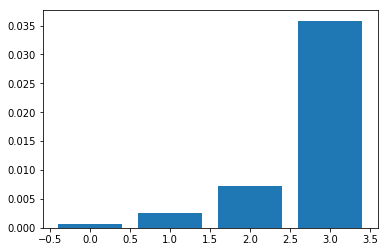

<BarContainer object of 4 artists>

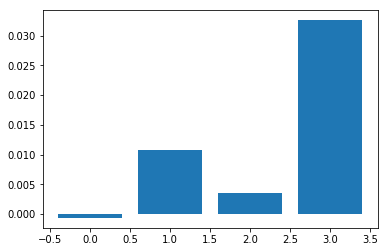

In [144]:
reg = DecisionTreeRegressor(max_depth=2,min_samples_leaf=50,random_state=0,
#                             min_samples_split=500,
                            min_impurity_decrease=3.5e-6,
                           )
# reg = lgbm.LGBMRegressor(max_depth=10,min_child_samples=5,random_state=0,n_estimators=1,learning_rate=1,importance_type ='gain')

reg.fit(X[['pct','close/120ma']],Y['r_t2'])
importance = pd.Series(reg.feature_importances_,index=['pct','close/120ma']).sort_values(ascending=False)
importance[importance>0]
(importance>0).sum()
# reg.predict(X)

y_pred = pd.DataFrame(reg.predict(X[['pct','close/120ma']]),index=Y.index,columns=['pred'])
y_pred['pred_rank'] = y_pred.groupby('date')['pred'].rank(ascending=False,method='min')
y_pred['pred_rank_pct'] = y_pred.groupby('date')['pred'].rank(ascending=False,pct=True)
y_pred.head()
Y2 = Y.join(y_pred,how='left')
res = Y2.groupby('pred').agg(['mean','median','max','min','size']).sort_index()
res
plt.bar(np.arange(len(res)),res[('r_t2','mean')])
plt.show()
plt.bar(np.arange(len(res)),res[('r_t1','mean')])

# reg.predict(X)

(113, 6)

r_t1                     r_t2               
                mean    median size      mean    median size
date                                                        
2016-01-04  0.086088  0.086088    2  0.093477  0.093477    2
2016-02-05  0.074830  0.074830    1  0.095238  0.095238    1
2016-02-25  0.052837  0.052837    2  0.088135  0.088135    2
2016-02-29  0.021153  0.006272    4  0.089219  0.068031    4
2016-03-04 -0.002739 -0.002739    2  0.008147  0.008147    2

,r_t1_mean,r_t1_median,r_t1_size,r_t2_mean,r_t2_median,r_t2_size,idx,r_t2_mean_0,r_t2_median_0,r_t2_mean_1,r_t2_median_1
date,,,,,,,,,,,
2020-05-25,0.026804,0.026804,1.0,-0.004124,-0.004124,1.0,1067,-0.004124,-0.004124,0.0,0.0
2020-05-26,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1068,0.000000,0.000000,0.0,0.0
2020-05-27,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1069,0.000000,0.000000,0.0,0.0
2020-05-28,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1070,0.000000,0.000000,0.0,0.0
2020-05-29,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1071,0.000000,0.000000,0.0,0.0


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1
date,,,,,,
2016-01-04,1.086088,1.086088,1.0,1.0,1.093477,1.093477
2016-01-05,1.086088,1.086088,1.0,1.0,1.093477,1.093477
2016-01-06,1.086088,1.086088,1.0,1.0,1.093477,1.093477
2016-01-07,1.086088,1.086088,1.0,1.0,1.093477,1.093477
2016-01-08,1.086088,1.086088,1.0,1.0,1.093477,1.093477


C:\Users\dell-pc\Anaconda3.6\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5,1,'val_r_t1_mean withdraw')

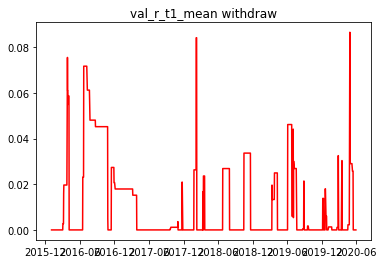

Text(0.5,1,'val_r_t1_median withdraw')

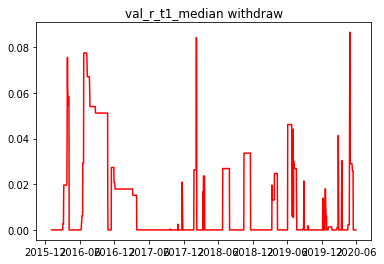

Text(0.5,1,'val_r_t2_mean_0 withdraw')

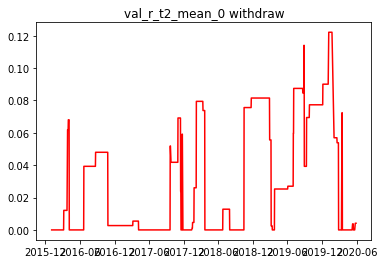

Text(0.5,1,'val_r_t2_median_0 withdraw')

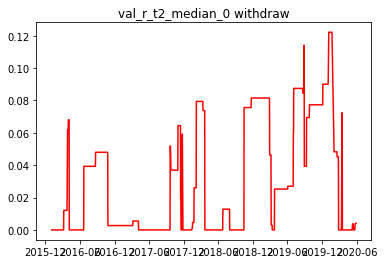

Text(0.5,1,'val_r_t2_mean_1 withdraw')

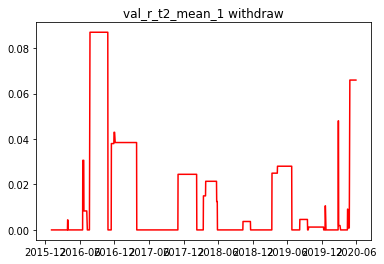

Text(0.5,1,'val_r_t2_median_1 withdraw')

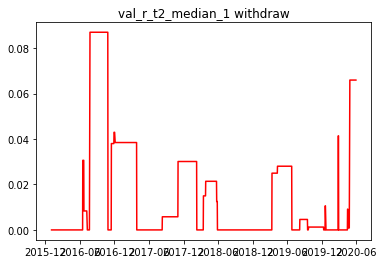

Text(0.5,1,'val_r_t2_mean withdraw')

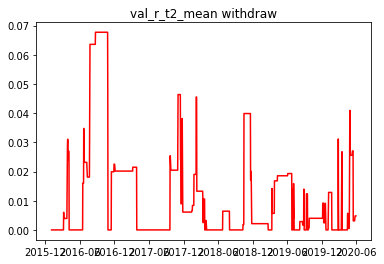

Text(0.5,1,'val_r_t2_median withdraw')

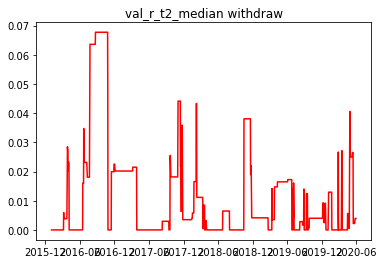

,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,...,cummax_val_r_t2_median_0,withdraw_val_r_t2_median_0,cummax_val_r_t2_mean_1,withdraw_val_r_t2_mean_1,cummax_val_r_t2_median_1,withdraw_val_r_t2_median_1,cummax_val_r_t2_mean,withdraw_val_r_t2_mean,cummax_val_r_t2_median,withdraw_val_r_t2_median
date,,,,,,,,,,,,,,,,,,,,,
2020-04-30,NaN,NaN,NaN,NaN,NaN,NaN,6.653271,6.571902,2.034511,2.080136,...,2.080136,0.000000,3.205516,0.065952,3.202807,0.065952,2.580326,0.025585,2.600894,0.025006
2020-05-06,NaN,NaN,NaN,NaN,NaN,NaN,6.653271,6.571902,2.034511,2.080136,...,2.080136,0.000000,3.205516,0.065952,3.202807,0.065952,2.580326,0.025585,2.600894,0.025006
2020-05-07,NaN,NaN,NaN,NaN,NaN,NaN,6.653271,6.571902,2.034511,2.080136,...,2.080136,0.000000,3.205516,0.065952,3.202807,0.065952,2.580326,0.025585,2.600894,0.025006
2020-05-08,NaN,NaN,NaN,NaN,NaN,NaN,6.653271,6.571902,2.034511,2.080136,...,2.080136,0.000000,3.205516,0.065952,3.202807,0.065952,2.580326,0.025585,2.600894,0.025006
2020-05-11,0.003424,0.003424,1.0,-0.003735,-0.003735,1.0,6.676049,6.594401,2.026912,2.072367,...,2.080136,0.003735,3.205516,0.065952,3.202807,0.065952,2.580326,0.027057,2.600894,0.026500
2020-05-12,NaN,NaN,NaN,NaN,NaN,NaN,6.676049,6.594401,2.026912,2.072367,...,2.080136,0.003735,3.205516,0.065952,3.202807,0.065952,2.580326,0.027057,2.600894,0.026500
2020-05-13,NaN,NaN,NaN,NaN,NaN,NaN,6.676049,6.594401,2.026912,2.072367,...,2.080136,0.003735,3.205516,0.065952,3.202807,0.065952,2.580326,0.027057,2.600894,0.026500
2020-05-14,NaN,NaN,NaN,NaN,NaN,NaN,6.676049,6.594401,2.026912,2.072367,...,2.080136,0.003735,3.205516,0.065952,3.202807,0.065952,2.580326,0.027057,2.600894,0.026500
2020-05-15,0.034078,0.034078,1.0,0.061011,0.061011,1.0,6.903558,6.819128,2.150577,2.198805,...,2.198805,0.000000,3.205516,0.065952,3.202807,0.065952,2.580326,0.003094,2.600894,0.002193


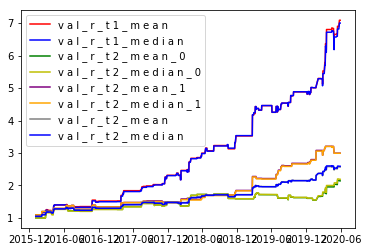


--------------------
M


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.035287,0.035135,0.013797,0.014035,0.020329,0.020295,0.016915,0.017008
median,0.003009,0.003009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
std,0.063714,0.064633,0.052928,0.052647,0.049906,0.049509,0.037026,0.036822


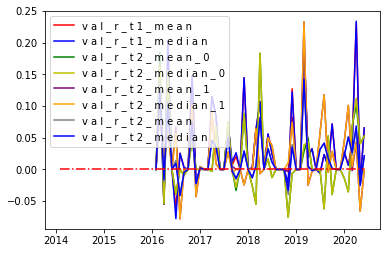


--------------------
Q


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-31,0.092018,0.076465,0.120896,0.099092,0.110677,0.118083,0.115558,0.109011


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.110252,0.109324,0.042966,0.044426,0.060041,0.060036,0.051209,0.051777
median,0.096578,0.100331,0.043417,0.046054,0.057930,0.057930,0.040529,0.040367
std,0.080712,0.077636,0.070185,0.073367,0.074283,0.074965,0.055641,0.057122


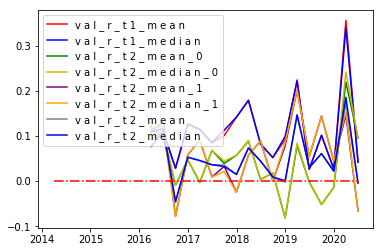


--------------------
A


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-31,0.399550,0.379057,0.266182,0.259185,0.225804,0.222221,0.245092,0.239878
2017-12-31,0.521185,0.537497,0.170325,0.176264,0.109416,0.097335,0.139003,0.135624
2018-12-31,0.524875,0.534804,0.073566,0.073566,0.241752,0.250207,0.157806,0.161450
2019-12-31,0.422178,0.419673,0.007710,0.012014,0.514661,0.514661,0.280040,0.281206
2020-12-31,0.413635,0.395449,0.335960,0.360763,0.070514,0.077219,0.167228,0.181242


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.456284,0.453296,0.170749,0.176358,0.232429,0.232329,0.197834,0.199880
median,0.422178,0.419673,0.170325,0.176264,0.225804,0.222221,0.167228,0.181242
std,0.061477,0.077009,0.134563,0.140036,0.174022,0.174940,0.061219,0.059512


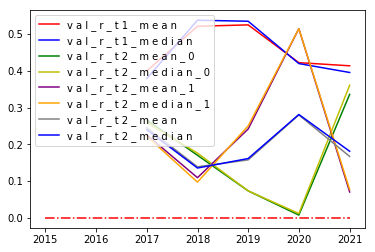

In [145]:
tmp_day = Y2[(Y2['pred']>0.01)].groupby('date')[['r_t1','r_t2']].agg(['mean','median','size'])
tmp_day.shape
tmp_day.head()



day_r = tmp_day.reindex(date[date>eval_date_start]).fillna(0)

day_r.columns = ['_'.join(col) for col in day_r]
day_r['idx'] = np.arange(len(day_r))
day_r_t2_0=day_r[['r_t2_mean','r_t2_median']].add_suffix('_0')
day_r_t2_0.loc[day_r['idx']%2==0,:]=0

day_r_t2_1=day_r[['r_t2_mean','r_t2_median']].add_suffix('_1')
day_r_t2_1.loc[day_r['idx']%2==1,:]=0
# day_r.tail(50)
# day_r_t2_0.tail(50)
# day_r_t2_1.tail(50)

day_r = pd.concat([day_r,day_r_t2_0,day_r_t2_1],axis=1)
day_r.tail(5)


day_v = (day_r[['r_t1_mean','r_t1_median','r_t2_mean_0','r_t2_median_0','r_t2_mean_1','r_t2_median_1']]+1).cumprod().add_prefix('val_')
day_v.head()
day_v['val_r_t2_mean'] = (day_v['val_r_t2_mean_0']+day_v['val_r_t2_mean_1'])/2
day_v['val_r_t2_median'] = (day_v['val_r_t2_median_0']+day_v['val_r_t2_median_1'])/2
result_day = tmp_day.reindex(date).join(day_v,how='left')
result_day.head()
for col in day_v.columns:
    result_day['cummax_{}'.format(col)] = result_day[col].expanding().max() 
    result_day['withdraw_{}'.format(col)] = 1-result_day[col]/result_day['cummax_{}'.format(col)]
    plt.plot(result_day.index,result_day['withdraw_{}'.format(col)],color='r')
    plt.title('{} withdraw'.format(col))
    plt.show()

result_day.tail(20)


f= plt.figure()
for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
    _ = plt.plot(day_v.index,day_v[col],color=c,label=' '.join(col))
_ = plt.legend(loc='upper left')
plt.show()
# f.savefig('val_curve.png')



result_dict = {'day':result_day}

for key,p in zip(['month','quarter','year'],['M','Q','A']):
    result_period = result_day[day_v.columns].resample(p).apply(lambda x:x[-1]/x[0]-1)
    print('\n'+'-'*20+'\n'+p)
    result_dict[key] = result_period
    result_dict[key+'_stats'] = result_period.agg(['mean','median','std'])
    result_dict[key]
    result_dict[key+'_stats']
    
    for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
        _ = plt.plot(result_period.index,result_period[col],color=c,label=' '.join(col))
    _ = plt.legend(loc='upper left')
    _ = plt.plot(result_period.index,[0]*len(result_period),color='r',linestyle='-.')
    plt.show()

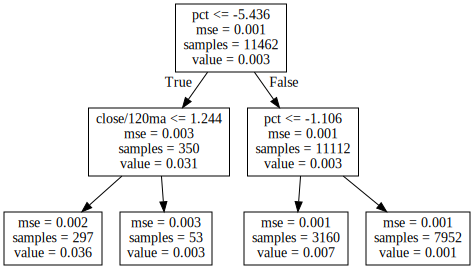

In [152]:
graph = tree.export_graphviz(reg, out_file=None, feature_names=['pct','close/120ma'])
# print(graph)
# graph
graphviz.Source(graph,format='png')
import pickle
with open('reg.pkl',mode='wb') as f:
    pickle.dump(reg,f)

In [48]:


with pd.ExcelWriter("result.xlsx") as writer:
    Y2[(Y2['pred']>0.01)].to_excel(writer,sheet_name='signal_0.01')
    for k in sorted(result_dict.keys()):
        result_dict[k].to_excel(writer,sheet_name=k)



In [100]:
mask_trend = [
    df['p15mean-std_5ma_pct'] > 0.15,
]

mask_low_pos = [
    df['pct'].fillna(-9999)<=-5.436,
    df['close/120ma'].fillna(-9999)<=1.244,
    df['close/60ma']<1.2,
#     df['close/60ma']<1.125,

#     df['close/30ma']<1.05, 
    df['close/5ma']<1.1,
    df['close/10ma']<1.1,

    df[['close/30ma','close/60ma','close/120ma','close/250ma']].max(axis=1)>0.9,
]


mask_basic =[   
    # 流动性、市值等基本限制 
#     mean     -2.309262e-03
#     median   -1.832455e-02
#     size   2373852
    df['amt']>=2,
    df['turnover_rate']<10,
    df['circ_mv']>50e4, 
    df['total_mv']>100e4,
    
#     (df['pb']<10) | (df['pe']>0),
    
    
#     df['close0']>5,
#     df['close0_rank']<100,
#     df['close0_rank']>10,
#     df['close0_pct']<0.015,
#     df['close0_pct']>0.01,

    df.index.get_level_values('code').str[:3]!='688',
]



mask_final = True
# masks = mask_big_rise+mask_basic+mask_trend
masks = mask_trend+mask_low_pos+mask_basic
# masks = mask_shrink_amt+mask_trend+mask_basic

# for m in masks:
for m in masks+[mask_date]:

    mask_final &= m
    m.sum(),len(m),round(m.sum()/len(m),4),round(mask_final.sum()/len(mask_final),4)

df_sample = df[mask_final]
df_sample.shape

(199754, 4593560, 0.0435, 0.0435)

(190113, 4593560, 0.0414, 0.0023)

(2938649, 4593560, 0.6397, 0.0006)

(3556357, 4593560, 0.7742, 0.0005)

(4473030, 4593560, 0.9738, 0.0005)

(4301818, 4593560, 0.9365, 0.0005)

(4110067, 4593560, 0.8947, 0.0005)

(1056950, 4593560, 0.2301, 0.0002)

(4348257, 4593560, 0.9466, 0.0002)

(2056374, 4593560, 0.4477, 0.0001)

(1433930, 4593560, 0.3122, 0.0001)

(4580262, 4593560, 0.9971, 0.0001)

(3453794, 4593560, 0.7519, 0.0001)

(255, 95)

In [101]:
# Y2.shape
# df_sample.shape
df_sample.reindex(Y2.index).loc[Y2['pred']>0.01,['pct','close/120ma']].agg(['max','min','size'])
df_sample.loc[df_sample['r_t2'].notnull(),features].fillna(-9999).shape
pred_tmp = pd.Series(reg.predict(df_sample.loc[df_sample['r_t2'].notnull(),features].fillna(-9999)),index=df_sample.index[df_sample['r_t2'].notnull()])
pred_tmp[pred_tmp>0.01]

,pct,close/120ma
max,-5.439007,1.243578
min,-10.032362,0.699274
size,297.000000,297.000000


(255, 78)

code       date      
000012.SZ  2020-02-27    0.035828
           2020-02-28    0.035828
000060.SZ  2019-03-08    0.035828
000066.SZ  2020-02-28    0.035828
000100.SZ  2019-12-11    0.035828
                           ...   
603712.SH  2019-03-08    0.035828
           2020-02-28    0.035828
603799.SH  2019-03-08    0.035828
           2019-12-11    0.035828
603993.SH  2019-03-08    0.035828
Length: 254, dtype: float64

(95, 6)

r_t1                     r_t2               
                mean    median size      mean    median size
date                                                        
2016-01-04  0.086088  0.086088    2  0.093477  0.093477    2
2016-02-25  0.059688  0.059688    1  0.085969  0.085969    1
2016-02-29  0.021153  0.006272    4  0.089219  0.068031    4
2016-03-04 -0.002739 -0.002739    2  0.008147  0.008147    2
2016-03-08 -0.013210 -0.013210    1 -0.012078 -0.012078    1

,r_t1_mean,r_t1_median,r_t1_size,r_t2_mean,r_t2_median,r_t2_size,idx,r_t2_mean_0,r_t2_median_0,r_t2_mean_1,r_t2_median_1
date,,,,,,,,,,,
2020-05-25,0.026804,0.026804,1.0,-0.004124,-0.004124,1.0,1067,-0.004124,-0.004124,0.0,0.0
2020-05-26,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1068,0.000000,0.000000,0.0,0.0
2020-05-27,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1069,0.000000,0.000000,0.0,0.0
2020-05-28,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1070,0.000000,0.000000,0.0,0.0
2020-05-29,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1071,0.000000,0.000000,0.0,0.0


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1
date,,,,,,
2016-01-04,1.086088,1.086088,1.0,1.0,1.093477,1.093477
2016-01-05,1.086088,1.086088,1.0,1.0,1.093477,1.093477
2016-01-06,1.086088,1.086088,1.0,1.0,1.093477,1.093477
2016-01-07,1.086088,1.086088,1.0,1.0,1.093477,1.093477
2016-01-08,1.086088,1.086088,1.0,1.0,1.093477,1.093477


C:\Users\dell-pc\Anaconda3.6\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5,1,'val_r_t1_mean withdraw')

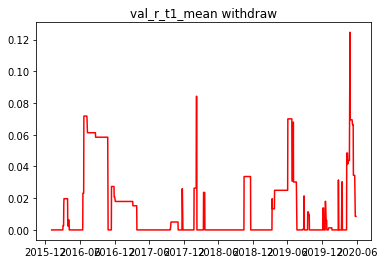

Text(0.5,1,'val_r_t1_median withdraw')

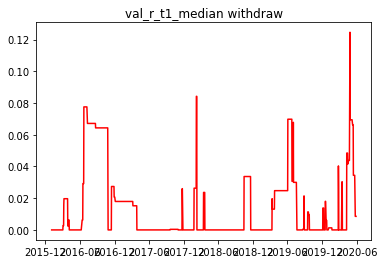

Text(0.5,1,'val_r_t2_mean_0 withdraw')

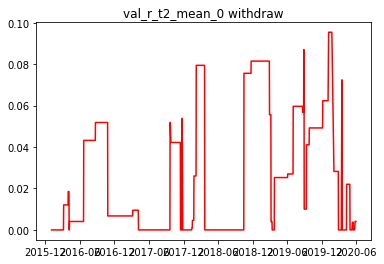

Text(0.5,1,'val_r_t2_median_0 withdraw')

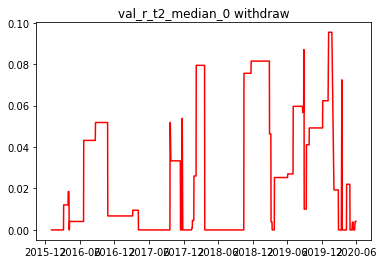

Text(0.5,1,'val_r_t2_mean_1 withdraw')

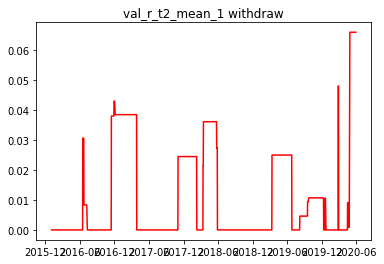

Text(0.5,1,'val_r_t2_median_1 withdraw')

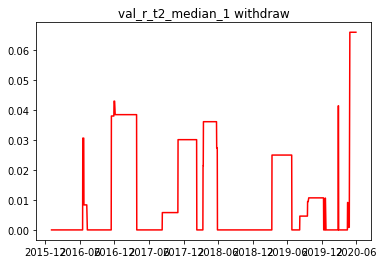

Text(0.5,1,'val_r_t2_mean withdraw')

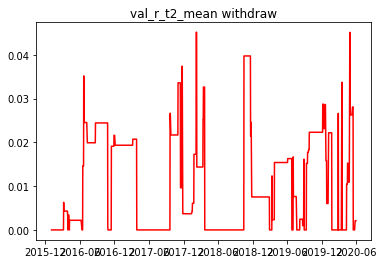

Text(0.5,1,'val_r_t2_median withdraw')

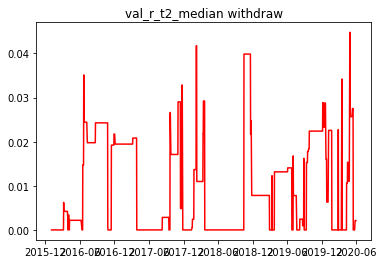

,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,...,cummax_val_r_t2_median_0,withdraw_val_r_t2_median_0,cummax_val_r_t2_mean_1,withdraw_val_r_t2_mean_1,cummax_val_r_t2_median_1,withdraw_val_r_t2_median_1,cummax_val_r_t2_mean,withdraw_val_r_t2_mean,cummax_val_r_t2_median,withdraw_val_r_t2_median
date,,,,,,,,,,,,,,,,,,,,,
2020-04-30,NaN,NaN,NaN,NaN,NaN,NaN,4.089162,3.937485,1.977455,2.003107,...,2.003107,0.000000,2.150894,0.065952,2.120098,0.065952,2.047000,0.026259,2.044205,0.025689
2020-05-06,NaN,NaN,NaN,NaN,NaN,NaN,4.089162,3.937485,1.977455,2.003107,...,2.003107,0.000000,2.150894,0.065952,2.120098,0.065952,2.047000,0.026259,2.044205,0.025689
2020-05-07,NaN,NaN,NaN,NaN,NaN,NaN,4.089162,3.937485,1.977455,2.003107,...,2.003107,0.000000,2.150894,0.065952,2.120098,0.065952,2.047000,0.026259,2.044205,0.025689
2020-05-08,NaN,NaN,NaN,NaN,NaN,NaN,4.089162,3.937485,1.977455,2.003107,...,2.003107,0.000000,2.150894,0.065952,2.120098,0.065952,2.047000,0.026259,2.044205,0.025689
2020-05-11,0.003424,0.003424,1.0,-0.003735,-0.003735,1.0,4.103162,3.950966,1.970070,1.995626,...,2.003107,0.003735,2.150894,0.065952,2.120098,0.065952,2.047000,0.028063,2.044205,0.027519
2020-05-12,NaN,NaN,NaN,NaN,NaN,NaN,4.103162,3.950966,1.970070,1.995626,...,2.003107,0.003735,2.150894,0.065952,2.120098,0.065952,2.047000,0.028063,2.044205,0.027519
2020-05-13,NaN,NaN,NaN,NaN,NaN,NaN,4.103162,3.950966,1.970070,1.995626,...,2.003107,0.003735,2.150894,0.065952,2.120098,0.065952,2.047000,0.028063,2.044205,0.027519
2020-05-14,NaN,NaN,NaN,NaN,NaN,NaN,4.103162,3.950966,1.970070,1.995626,...,2.003107,0.003735,2.150894,0.065952,2.120098,0.065952,2.047000,0.028063,2.044205,0.027519
2020-05-15,0.034078,0.034078,1.0,0.061011,0.061011,1.0,4.242991,4.085608,2.090266,2.117382,...,2.117382,0.000000,2.150894,0.065952,2.120098,0.065952,2.049653,0.000000,2.048828,0.000000


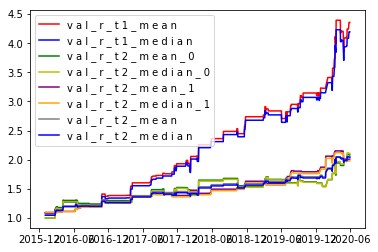


--------------------
M


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.025945,0.025272,0.013432,0.013455,0.012094,0.011815,0.012314,0.012214
median,0.002599,0.002599,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
std,0.051858,0.052245,0.048704,0.047496,0.034053,0.033917,0.025573,0.025236


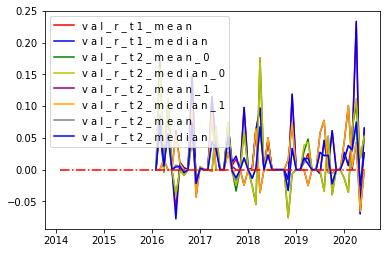


--------------------
Q


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-03-31,0.079590,0.063857,0.178091,0.155175,0.016174,0.016174,0.093518,0.082571


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.083324,0.080926,0.044161,0.044972,0.035531,0.034720,0.038906,0.038933
median,0.065966,0.058099,0.043186,0.047998,0.038479,0.035265,0.026174,0.027473
std,0.084552,0.082091,0.070920,0.072152,0.050460,0.050916,0.042926,0.044571


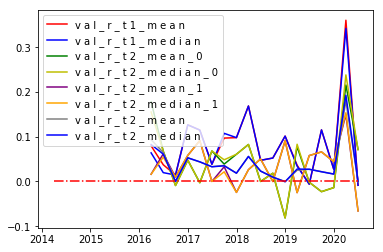


--------------------
A


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-31,0.274672,0.234745,0.297106,0.271875,0.152843,0.144797,0.221754,0.205499
2017-12-31,0.394180,0.407653,0.173771,0.184645,0.099510,0.087537,0.137170,0.136477
2018-12-31,0.418332,0.418333,0.012652,0.012652,0.175913,0.175913,0.090453,0.090146
2019-12-31,0.180031,0.177570,0.036797,0.041906,0.148136,0.148135,0.094012,0.096296
2020-12-31,0.348671,0.330581,0.302250,0.326427,0.073596,0.077394,0.178934,0.192891


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.323177,0.313777,0.164515,0.167501,0.130000,0.126755,0.144465,0.144262
median,0.348671,0.330581,0.173771,0.184645,0.148136,0.144797,0.137170,0.136477
std,0.096940,0.105860,0.137851,0.138020,0.042041,0.042349,0.056297,0.053396


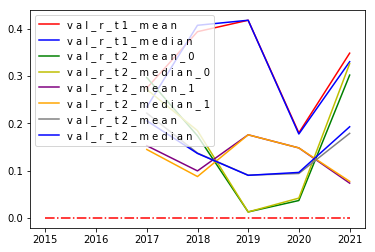

In [102]:
tmp_day = df_sample.groupby('date')[['r_t1','r_t2']].agg(['mean','median','size'])
tmp_day.shape
tmp_day.head()



day_r = tmp_day.reindex(date[date>eval_date_start]).fillna(0)

day_r.columns = ['_'.join(col) for col in day_r]
day_r['idx'] = np.arange(len(day_r))
day_r_t2_0=day_r[['r_t2_mean','r_t2_median']].add_suffix('_0')
day_r_t2_0.loc[day_r['idx']%2==0,:]=0

day_r_t2_1=day_r[['r_t2_mean','r_t2_median']].add_suffix('_1')
day_r_t2_1.loc[day_r['idx']%2==1,:]=0
# day_r.tail(50)
# day_r_t2_0.tail(50)
# day_r_t2_1.tail(50)

day_r = pd.concat([day_r,day_r_t2_0,day_r_t2_1],axis=1)
day_r.tail(5)


day_v = (day_r[['r_t1_mean','r_t1_median','r_t2_mean_0','r_t2_median_0','r_t2_mean_1','r_t2_median_1']]+1).cumprod().add_prefix('val_')
day_v.head()
day_v['val_r_t2_mean'] = (day_v['val_r_t2_mean_0']+day_v['val_r_t2_mean_1'])/2
day_v['val_r_t2_median'] = (day_v['val_r_t2_median_0']+day_v['val_r_t2_median_1'])/2
result_day = tmp_day.reindex(date).join(day_v,how='left')
result_day.head()
for col in day_v.columns:
    result_day['cummax_{}'.format(col)] = result_day[col].expanding().max() 
    result_day['withdraw_{}'.format(col)] = 1-result_day[col]/result_day['cummax_{}'.format(col)]
    plt.plot(result_day.index,result_day['withdraw_{}'.format(col)],color='r')
    plt.title('{} withdraw'.format(col))
    plt.show()

result_day.tail(20)


f= plt.figure()
for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
    _ = plt.plot(day_v.index,day_v[col],color=c,label=' '.join(col))
_ = plt.legend(loc='upper left')
plt.show()
# f.savefig('val_curve.png')



result_dict = {'day':result_day}

for key,p in zip(['month','quarter','year'],['M','Q','A']):
    result_period = result_day[day_v.columns].resample(p).apply(lambda x:x[-1]/x[0]-1)
    print('\n'+'-'*20+'\n'+p)
    result_dict[key] = result_period
    result_dict[key+'_stats'] = result_period.agg(['mean','median','std'])
    result_dict[key]
    result_dict[key+'_stats']
    
    for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
        _ = plt.plot(result_period.index,result_period[col],color=c,label=' '.join(col))
    _ = plt.legend(loc='upper left')
    _ = plt.plot(result_period.index,[0]*len(result_period),color='r',linestyle='-.')
    plt.show()

In [75]:
# df_sample[['pct','close/120ma']].agg(['max','min'])
df_sample.index.difference(Y2.index)

MultiIndex([('000735.SZ', '2020-05-28'),
            ('000735.SZ', '2020-05-29'),
            ('002511.SZ', '2020-05-28'),
            ('002511.SZ', '2020-05-29'),
            ('300699.SZ', '2020-05-28'),
            ('300725.SZ', '2020-05-28'),
            ('300725.SZ', '2020-05-29'),
            ('600037.SH', '2020-05-26'),
            ('600057.SH', '2020-05-28'),
            ('600515.SH', '2020-05-28'),
            ('600515.SH', '2020-05-29'),
            ('603195.SH', '2020-05-28'),
            ('603195.SH', '2020-05-29')],
           names=['code', 'date'])

In [28]:
train_end_idx = 250 *2-1
train_period = 10

ycols = ['r_t1','r_t2']
ycol = 'r_t2'

cnt=0
y_pred_list = []
while train_end_idx+2<=date_idx.max():
    
    mask_train_date = df_sample['date_idx']<=train_end_idx
    mask_y = df_sample[ycol].notnull()
    mask_train = mask_train_date & mask_y
    
    mask_test = (df_sample['date_idx']>=train_end_idx+2) & (df_sample['date_idx']<train_end_idx+12)
    
    X_train,y_train = df_sample.loc[mask_train,features].fillna(-9999),df_sample.loc[mask_train,ycol]
    X_test,y_test = df_sample.loc[mask_test,features].fillna(-9999),df_sample.loc[mask_test,ycol]
    
    sample_weight = pd.Series(1,index=X_train.index)
    mask_weight = df_sample.loc[mask_train,'date_idx']>train_end_idx-125
    sample_weight.loc[mask_weight]+= (df_sample.loc[mask_train,'date_idx']-train_end_idx+125)/125*4
    
    if len(X_test)==0:
        print(train_end_idx,X_train.shape,y_train.shape,X_test.shape,y_test.shape)
        train_end_idx+=train_period
#         cnt +=1
        continue

    
        

    reg = DecisionTreeRegressor(max_depth=10,min_samples_leaf=50, #max(50,len(X_train)//200),
                                min_weight_fraction_leaf = 0.005,
                                max_leaf_nodes=12,
                                min_impurity_decrease=3.5e-6,
                                random_state=0)
    _ = reg.fit(X_train,y_train,sample_weight=sample_weight.values)
#     pd.DataFrame(reg.predict(X_test),index = X_test.index,columns=['pred'])
    y_pred_list.append(pd.DataFrame(reg.predict(X_test),index = X_test.index,columns=['pred']))
    
    if cnt%10==0:
        print(train_end_idx,X_train.shape,y_train.shape,X_test.shape,y_test.shape)
        importance = pd.Series(reg.feature_importances_,index=features).sort_values(ascending=False)
        importance[importance>0]
    
    train_end_idx+=train_period
    cnt +=1
#     break
    

499 (4054, 78) (4054,) (0, 78) (0,)
509 (4054, 78) (4054,) (20, 78) (20,)


day_pct            0.376171
close/120ma        0.226380
close/5ma          0.084309
prev_day_pct       0.073146
p5mean_5ma_pct     0.064295
turnover_rate_f    0.055891
pe_ttm             0.049304
close/20ma         0.041713
20ma_pct           0.028791
dtype: float64

609 (4780, 78) (4780,) (482, 78) (482,)


close/5ma          0.298987
p30std_5ma_pct     0.175668
60ma_pct           0.104801
pct                0.098936
turnover_rate_f    0.080896
prev_day_pct       0.055673
prev_pct           0.053011
p30mean_5ma_pct    0.048261
p25mean_5ma_pct    0.042841
close/10ma         0.040927
dtype: float64

709 (5884, 78) (5884,) (38, 78) (38,)


pct                    0.318735
close/250ma            0.118323
close/20ma             0.084683
turnover_rate_f        0.081522
close/5ma              0.067271
free_share             0.064449
pb*pe                  0.059352
p30mean-std_5ma_pct    0.058598
p20median_5ma_pct      0.056740
volume_ratio           0.049698
p10std_5ma_pct         0.040630
dtype: float64

809 (6646, 78) (6646,) (20, 78) (20,)


pct                    0.368869
close/120ma            0.156502
close/5ma              0.105059
close/20ma             0.064570
p30mean_5ma_pct        0.062026
close0_pct             0.059884
prev_day_pct           0.051882
p30mean-std_5ma_pct    0.047074
turnover_rate          0.045063
volume_ratio           0.039071
dtype: float64

909 (7758, 78) (7758,) (98, 78) (98,)


pct                    0.315445
close/10ma             0.121189
close/60ma             0.108746
p30std_5ma_pct         0.088417
volume_ratio           0.072802
p30mean_5ma_pct        0.067108
turnover_rate_f        0.063029
p30mean-std_5ma_pct    0.056141
pb*pe_ttm              0.055585
prev_pct               0.051539
dtype: float64

1009 (8834, 78) (8834,) (220, 78) (220,)


pct                    0.294231
prev_day_pct           0.176389
p30mean-std_5ma_pct    0.139834
p25std_5ma_pct         0.106199
5ma_pct                0.070278
close/5ma              0.067337
p30mean_5ma_pct        0.063191
close/120ma            0.042161
turnover_rate_f        0.040379
dtype: float64

1109 (9818, 78) (9818,) (61, 78) (61,)


pct                  0.306564
close/5ma            0.130677
p30std_5ma_pct       0.120344
turnover_rate_f      0.087004
p10median_5ma_pct    0.070485
p30mean_5ma_pct      0.069408
60ma_pct             0.066537
prev_pct             0.061319
close0               0.048575
close/30ma           0.039087
dtype: float64

1209 (10139, 78) (10139,) (5, 78) (5,)


pct                    0.295613
p30std_5ma_pct         0.126464
close/5ma              0.115769
prev_pct               0.074121
turnover_rate_f        0.073049
p30mean-std_5ma_pct    0.068701
prev_day_pct           0.068107
60ma_pct               0.052817
p30mean_5ma_pct        0.045216
close0_pct             0.042719
p10mean-std_5ma_pct    0.037422
dtype: float64

1299 (12308, 78) (12308,) (0, 78) (0,)
1319 (12334, 78) (12334,) (46, 78) (46,)


pct                    0.375632
5ma_pct                0.120161
p30mean-std_5ma_pct    0.111786
volume_ratio           0.076885
close/5ma              0.058718
prev_pct               0.057014
30ma_pct               0.055551
p5max_abs_pct          0.052798
avg0                   0.047095
p15mean-std_5ma_pct    0.044360
dtype: float64

1419 (13545, 78) (13545,) (41, 78) (41,)


pct                 0.375439
close/5ma           0.118337
turnover_rate_f     0.111193
p30std_5ma_pct      0.109089
prev_day_pct        0.092994
p30mean_5ma_pct     0.069186
close/30ma          0.042285
close/120ma         0.041018
p5median_5ma_pct    0.040459
dtype: float64

1519 (14853, 78) (14853,) (114, 78) (114,)


close/5ma              0.551758
pct                    0.093632
volume_ratio           0.055010
p20std_5ma_pct         0.049538
total_mv               0.048321
pb                     0.046726
p30mean-std_5ma_pct    0.042258
turnover_rate          0.041865
p30mean_5ma_pct        0.037684
float_share            0.033208
dtype: float64

In [29]:
y_pred = pd.concat(y_pred_list,axis=0)
y_pred['pred_rank'] = y_pred.groupby('date')['pred'].rank(ascending=False,method='min')
y_pred['pred_rank_pct'] = y_pred.groupby('date')['pred'].rank(ascending=False,pct=True)
y_pred.shape
y_pred.head()

Y = df.loc[mask_final&mask_date,ycols]


Y2 = Y.join(y_pred,how='left')
# res = Y2.groupby('pred').agg(['mean','median','max','min','size']).sort_index()
# res
# plt.bar(np.arange(len(res)),res[('r_t2','mean')])
# plt.show()
# plt.bar(np.arange(len(res)),res[('r_t1','mean')])


(11479, 3)

pred  pred_rank  pred_rank_pct
code      date                                          
000423.SZ 2016-02-23 -0.007975        2.0       1.000000
          2016-02-24 -0.007975        3.0       0.875000
000961.SZ 2016-02-16 -0.004577        2.0       1.000000
002007.SZ 2016-02-05 -0.007975        2.0       0.666667
002416.SZ 2016-02-04  0.000592        1.0       1.000000

In [30]:
tmp_day = Y2[(Y2['pred']>0.005) & (Y2['pred_rank']<=1)].groupby('date')[['r_t1','r_t2']].agg(['mean','median','size'])
tmp_day.shape
tmp_day.head()



day_r = tmp_day.reindex(date).fillna(0)

day_r.columns = ['_'.join(col) for col in day_r]
day_r['idx'] = np.arange(len(day_r))
day_r_t2_0=day_r[['r_t2_mean','r_t2_median']].add_suffix('_0')
day_r_t2_0.loc[day_r['idx']%2==0,:]=0

day_r_t2_1=day_r[['r_t2_mean','r_t2_median']].add_suffix('_1')
day_r_t2_1.loc[day_r['idx']%2==1,:]=0
# day_r.tail(50)
# day_r_t2_0.tail(50)
# day_r_t2_1.tail(50)

day_r = pd.concat([day_r,day_r_t2_0,day_r_t2_1],axis=1)
day_r.tail(5)

(693, 6)

r_t1                     r_t2               
                mean    median size      mean    median size
date                                                        
2016-02-16  0.155877  0.155877    1  0.200503  0.200503    1
2016-02-23  0.010666  0.010666    1 -0.085751 -0.085751    1
2016-02-24 -0.083580 -0.083580    1 -0.131279 -0.131279    1
2016-02-25  0.045987  0.045987    1  0.090301  0.090301    1
2016-02-29  0.034103  0.016667    3  0.098604  0.075000    3

,r_t1_mean,r_t1_median,r_t1_size,r_t2_mean,r_t2_median,r_t2_size,idx,r_t2_mean_0,r_t2_median_0,r_t2_mean_1,r_t2_median_1
date,,,,,,,,,,,
2020-05-26,-0.017742,-0.017742,2.0,-0.013730,-0.013730,2.0,1556,0.000000,0.000000,-0.01373,-0.01373
2020-05-27,0.002269,0.002269,1.0,0.023071,0.023071,1.0,1557,0.023071,0.023071,0.00000,0.00000
2020-05-28,0.000000,0.000000,1.0,0.000000,0.000000,1.0,1558,0.000000,0.000000,0.00000,0.00000
2020-05-29,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1559,0.000000,0.000000,0.00000,0.00000
2014-07-15,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1560,0.000000,0.000000,0.00000,0.00000


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1
date,,,,,,
2014-01-02,1.0,1.0,1.0,1.0,1.0,1.0
2014-01-03,1.0,1.0,1.0,1.0,1.0,1.0
2014-01-06,1.0,1.0,1.0,1.0,1.0,1.0
2014-01-07,1.0,1.0,1.0,1.0,1.0,1.0
2014-01-08,1.0,1.0,1.0,1.0,1.0,1.0


C:\Users\dell-pc\Anaconda3.6\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014-01-07,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2014-01-08,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Text(0.5,1,'val_r_t1_mean withdraw')

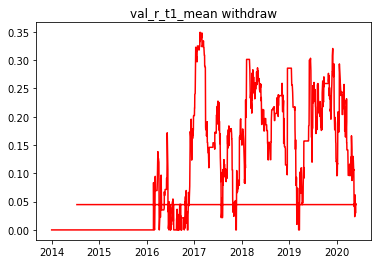

Text(0.5,1,'val_r_t1_median withdraw')

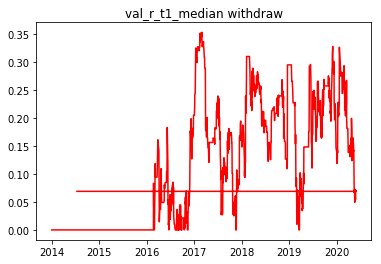

Text(0.5,1,'val_r_t2_mean_0 withdraw')

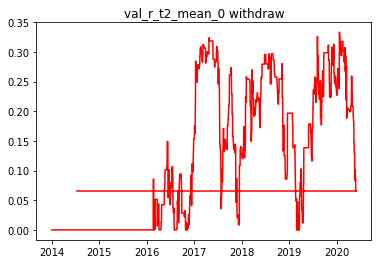

Text(0.5,1,'val_r_t2_median_0 withdraw')

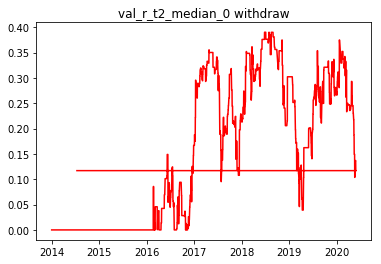

Text(0.5,1,'val_r_t2_mean_1 withdraw')

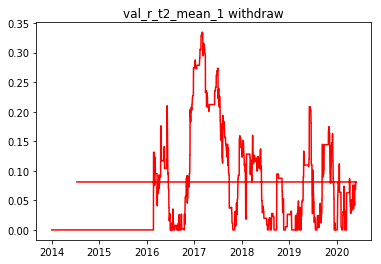

Text(0.5,1,'val_r_t2_median_1 withdraw')

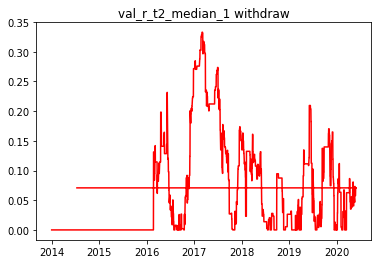

Text(0.5,1,'val_r_t2_mean withdraw')

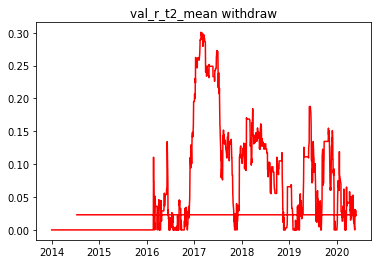

Text(0.5,1,'val_r_t2_median withdraw')

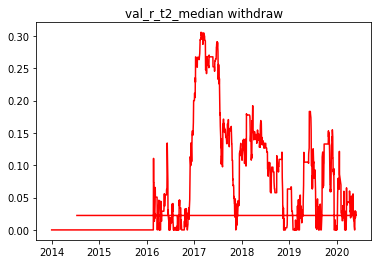

,"(r_t1, mean)","(r_t1, median)","(r_t1, size)","(r_t2, mean)","(r_t2, median)","(r_t2, size)",val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,...,cummax_val_r_t2_median_0,withdraw_val_r_t2_median_0,cummax_val_r_t2_mean_1,withdraw_val_r_t2_mean_1,cummax_val_r_t2_median_1,withdraw_val_r_t2_median_1,cummax_val_r_t2_mean,withdraw_val_r_t2_mean,cummax_val_r_t2_median,withdraw_val_r_t2_median
date,,,,,,,,,,,,,,,,,,,,,
2020-04-30,0.002030,0.002030,1.0,0.025667,0.025667,1.0,1.632451,1.384058,1.425232,1.178610,...,1.562202,0.245546,4.003356,0.033576,3.61264,0.038544,2.705592,0.021624,2.382585,0.023748
2020-05-06,-0.045853,-0.045853,1.0,-0.043830,-0.043830,1.0,1.557598,1.320595,1.425232,1.178610,...,1.562202,0.245546,4.003356,0.075934,3.61264,0.080684,2.705592,0.052962,2.382585,0.055696
2020-05-07,0.009299,0.009299,2.0,0.020115,0.020115,2.0,1.572082,1.332875,1.453902,1.202318,...,1.562202,0.230369,4.003356,0.075934,3.61264,0.080684,2.705592,0.047664,2.382585,0.050721
2020-05-08,-0.002079,-0.002079,1.0,0.043659,0.043659,1.0,1.568814,1.330104,1.453902,1.202318,...,1.562202,0.230369,4.003356,0.035590,3.61264,0.040548,2.705592,0.017816,2.382585,0.020292
2020-05-11,0.020833,0.020833,1.0,0.016667,0.016667,1.0,1.601498,1.357815,1.478133,1.222357,...,1.562202,0.217542,4.003356,0.035590,3.61264,0.040548,2.705592,0.013338,2.382585,0.016087
2020-05-12,-0.001423,-0.001423,2.0,-0.010899,-0.010899,2.0,1.599218,1.355882,1.478133,1.222357,...,1.562202,0.217542,4.003356,0.046101,3.61264,0.051005,2.705592,0.021115,2.382585,0.024015
2020-05-13,0.047307,0.047307,1.0,0.038574,0.038574,1.0,1.674873,1.420025,1.535150,1.269508,...,1.562202,0.187360,4.003356,0.046101,3.61264,0.051005,2.705592,0.010578,2.382585,0.014120
2020-05-14,0.019020,0.019020,2.0,-0.005270,-0.005270,2.0,1.706728,1.447033,1.535150,1.269508,...,1.562202,0.187360,4.003356,0.051129,3.61264,0.056006,2.705592,0.014297,2.382585,0.017912
2020-05-15,0.005567,0.019615,5.0,0.021535,0.046693,5.0,1.716230,1.475417,1.568209,1.328785,...,1.562202,0.149415,4.003356,0.051129,3.61264,0.056006,2.705592,0.008188,2.382585,0.005472


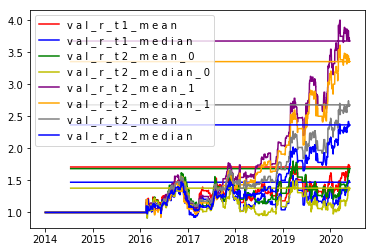


--------------------
M


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-02-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-03-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-04-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-05-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-07-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-08-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-09-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.009875,0.007999,0.005752,0.002771,0.017607,0.016602,0.012063,0.010351
median,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
std,0.089383,0.090732,0.078833,0.076703,0.070171,0.068917,0.062732,0.061429


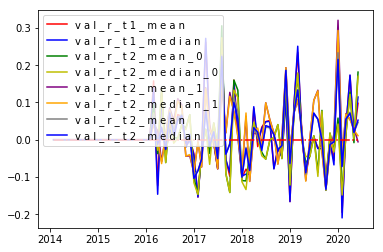


--------------------
Q


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-03-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-06-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-09-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-03-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-06-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-09-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-03-31,0.069780,0.023643,0.054116,0.041193,0.126326,0.101988,0.090221,0.071590


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.023291,0.017942,0.022504,0.014106,0.057061,0.054246,0.041092,0.036328
median,0.000000,0.000000,0.000000,0.000000,0.000799,0.000000,0.000000,0.000000
std,0.114171,0.113477,0.102274,0.098086,0.134026,0.130617,0.103160,0.098764


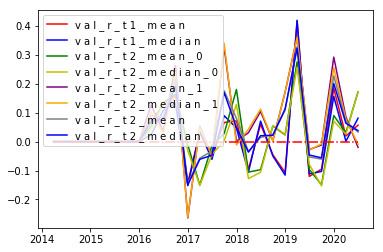


--------------------
A


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
date,,,,,,,,
2014-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-12-31,0.252053,0.135732,0.368295,0.301463,0.150238,0.061802,0.259267,0.181632
2017-12-31,0.106100,0.091434,0.030272,-0.061389,0.328960,0.320626,0.166686,0.110248
2018-12-31,-0.147289,-0.160280,-0.078565,-0.107807,0.337583,0.362438,0.137929,0.143506
2019-12-31,0.330531,0.304028,0.060679,0.041899,0.691165,0.645289,0.446228,0.426108
2020-12-31,0.077661,0.082425,0.208712,0.202974,0.063845,0.067934,0.105452,0.104028


,val_r_t1_mean,val_r_t1_median,val_r_t2_mean_0,val_r_t2_median_0,val_r_t2_mean_1,val_r_t2_median_1,val_r_t2_mean,val_r_t2_median
mean,0.088437,0.064763,0.084199,0.053877,0.224542,0.208299,0.159366,0.137932
median,0.077661,0.082425,0.030272,0.000000,0.150238,0.067934,0.137929,0.110248
std,0.161770,0.142794,0.152942,0.146575,0.249533,0.243337,0.156250,0.144310


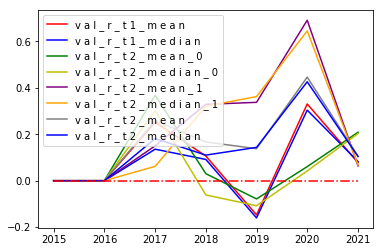

In [31]:
day_v = (day_r[['r_t1_mean','r_t1_median','r_t2_mean_0','r_t2_median_0','r_t2_mean_1','r_t2_median_1']]+1).cumprod().add_prefix('val_')
day_v.head()
day_v['val_r_t2_mean'] = (day_v['val_r_t2_mean_0']+day_v['val_r_t2_mean_1'])/2
day_v['val_r_t2_median'] = (day_v['val_r_t2_median_0']+day_v['val_r_t2_median_1'])/2
result_day = tmp_day.reindex(date).join(day_v,how='left')
result_day.head()
for col in day_v.columns:
    result_day['cummax_{}'.format(col)] = result_day[col].expanding().max() 
    result_day['withdraw_{}'.format(col)] = 1-result_day[col]/result_day['cummax_{}'.format(col)]
    plt.plot(result_day.index,result_day['withdraw_{}'.format(col)],color='r')
    plt.title('{} withdraw'.format(col))
    plt.show()

result_day.tail(20)


f= plt.figure()
for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
    _ = plt.plot(day_v.index,day_v[col],color=c,label=' '.join(col))
_ = plt.legend(loc='upper left')
plt.show()
# f.savefig('val_curve.png')



result_dict = {'day':result_day}

for key,p in zip(['month','quarter','year'],['M','Q','A']):
    result_period = result_day[day_v.columns].resample(p).apply(lambda x:x[-1]/x[0]-1)
    print('\n'+'-'*20+'\n'+p)
    result_dict[key] = result_period
    result_dict[key+'_stats'] = result_period.agg(['mean','median','std'])
    result_dict[key]
    result_dict[key+'_stats']
    
    for col,c in zip(day_v.columns,['r','b','g','y','purple','orange','grey','b']):
        _ = plt.plot(result_period.index,result_period[col],color=c,label=' '.join(col))
    _ = plt.legend(loc='upper left')
    _ = plt.plot(result_period.index,[0]*len(result_period),color='r',linestyle='-.')
    plt.show()

In [94]:
sample_weight = pd.Series(1,index=X_train.index)
sample_weight

code       date      
000001.SZ  2017-09-07    1
           2017-09-08    1
           2017-11-27    1
           2017-11-28    1
           2019-01-24    1
                        ..
603993.SH  2019-03-01    1
           2019-03-04    1
           2019-03-05    1
           2019-03-08    1
           2019-03-11    1
Length: 15399, dtype: int64

In [95]:
mask_weight = df_sample.loc[mask_train,'date_idx']>train_end_idx-125
sample_weight.loc[mask_weight]+= (df_sample.loc[mask_train,'date_idx']-train_end_idx+125)/125*4
sample_weight

code       date      
000001.SZ  2017-09-07    1.0
           2017-09-08    1.0
           2017-11-27    1.0
           2017-11-28    1.0
           2019-01-24    1.0
                        ... 
603993.SH  2019-03-01    1.0
           2019-03-04    1.0
           2019-03-05    1.0
           2019-03-08    1.0
           2019-03-11    1.0
Length: 15399, dtype: float64

In [97]:
sample_weight[sample_weight>1].sort_values()

code       date      
600673.SH  2019-11-22    1.032
000800.SZ  2019-11-22    1.032
002368.SZ  2019-11-22    1.032
600406.SH  2019-11-22    1.032
000977.SZ  2019-11-22    1.032
                         ...  
000333.SZ  2020-05-15    4.680
000877.SZ  2020-05-15    4.680
000596.SZ  2020-05-15    4.680
300408.SZ  2020-05-15    4.680
603236.SH  2020-05-15    4.680
Length: 1762, dtype: float64